## Problem Set 2: Merging and regular expressions

**Total points (without extra credit)**: 30 

**Background on the policy context**: here, we're going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers 
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset2_inputdata` (need to unzip): 

- `jobs_clean`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers 


You can view a codebook here: https://docs.google.com/spreadsheets/d/1rF9GJEC8pPKxipD0TsoG9DVdqz3EJ-b-BHEtyioAX7I/edit?usp=sharing


In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import os

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/Users/mingyuezha/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 1. Reshaping data (13 points total)

Load the following dataset stored in `pset2_inputdata`: `debar.csv`

This represents employers temporarily banned from hiring workers (debar.csv); call this `debar`


View the head()


In [48]:
## your code here
debar = pd.read_csv("pset2_inputdata/debar.csv")
debar.head()

,Name,"City, State",Violation,Duration,Start date,End date
0,J&J Harvesting,"Leads, ND",Failure to respond to audit (partial response),2 years,1/19/2014,1/18/2016
1,"Stahlman Apiaries, Inc","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016
2,Trust Nursery,"Pulaski, NY",Failure to respond to audit (partial response),1 year,3/21/2014,3/20/2015
3,Anton Fertilizer Inc.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016
4,"Great Plains Fluid Service, Inc.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016


## 1.1 (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [49]:
## your code here
debar.shape[0]
debar.drop_duplicates("Name").shape[0]
print("There are multiple rows for some employers")

114

98

There are multiple rows for some employers


## 1.2 Investigating duplicated rows (2 points)

A. Create a new column in `debar`--`is_repeated`-- that tells us whether an employer (`Name`) is repeated > 1 times

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using value_counts() on the `Name` variable and extracting the index from that value counts 
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [50]:
## your code here
repeated_names = debar.Name.value_counts()
repeated_names = repeated_names[repeated_names > 1].index
debar["is_repeated"] = debar["Name"].isin(repeated_names)

print(debar[debar["is_repeated"]])
print("Interpretation: 32 violations come from 16 companies, almost all for impeding or not responding to the audit process or not paying the audit fee. Companies are being disbarred for failing bureaucratic tasks, not human rights violations.")

mult_debar = debar[debar["is_repeated"]]
mult_debar.shape
mult_debar.head()

                                        Name       City, State  \
6                    Annabella Land & Cattle     Annabella, UT   
7                        Autumn Hill Orchard        Groton, MA   
8      Caddo Creek Ranch, dba Paradise Ranch         Caddo, TX   
11                     Loewen Harvesting LLC   Brownsville, TX   
12               Rollo Farm Labor Contractor         Miami, FL   
14                             Sharon Mathis        Tifton, GA   
15                                 SRT Farms        Morton, TX   
16                               Mark Duncan     Roosevelt, UT   
17          Maple Ridge Custom Services, LLC     Altheimer, AK   
18                                 F&W Farms       Ingalls, KS   
19                        Cisco Produce Inc.         Cairo, GA   
21   Old Tree Farms/Verpaalen Custom Service         Volga, SD   
24               Rollo Farm Labor Contractor         Miami, FL   
25                     Loewen Harvesting LLC    Brownfield, TX   
28     Cad

(32, 7)

,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,True
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,True
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,True


## 1.3 Reshape mult_debar to wide to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data 
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in this data (eg converting `Violation` to lowercase; replacing spelled-out states with two-dig state codes)

We're going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row's violation is the same 

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

Print the head and shape

In [51]:
## your code here

corrections = {
    "Caddo, Texas": "Caddo, TX",
    "Annabella, Utah" : "Annabella, UT",
    "Lyons, Georgia" : "Lyons, GA",
    "Altheimer, AK" : "Altheimer, AR",
    "Brownsville, TX" : "Brownfield, TX",
}
mult_debar_states = mult_debar.copy()
mult_debar_states["City, State"] = mult_debar_states["City, State"].apply(lambda s:corrections[s] if s in corrections.keys() else s)

first_violation = mult_debar_states.drop_duplicates(subset=["Name","City, State"], keep="first")
second_violation = mult_debar_states.drop_duplicates(subset=["Name","City, State"], keep="last")

mult_debar_wide = pd.merge(first_violation, second_violation, on=["Name","City, State"])
mult_debar_wide["start_date_viol1"] = mult_debar_wide["Start date_x"]
mult_debar_wide["start_date_viol2"] = mult_debar_wide["Start date_y"]

mult_debar_wide = mult_debar_wide.set_index(["Name", "City, State"])
mult_debar_wide = mult_debar_wide[["start_date_viol1", "start_date_viol2"]]

mult_debar_wide.head()
mult_debar_wide.shape

,,start_date_viol1,start_date_viol2
Name,"City, State",,
Annabella Land & Cattle,"Annabella, UT",5/9/2014,5/9/2014
Autumn Hill Orchard,"Groton, MA",7/6/2014,7/6/2014
"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",7/20/2014,7/20/2014
Loewen Harvesting LLC,"Brownfield, TX",8/20/2014,8/20/2014
Rollo Farm Labor Contractor,"Miami, FL",8/23/2014,8/23/2014


(16, 2)

## 1.4 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning- `debar`
    - For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == viol1`
    - For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
    - Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

In [52]:
## your code here
mult_debar_wide["is_dup"] = mult_debar_wide["start_date_viol1"] == mult_debar_wide["start_date_viol2"]
duplicate_employers = [pair[0] for pair in mult_debar_wide[mult_debar_wide["is_dup"]].index]

debar["is_dup"] = debar["Name"].isin(duplicate_employers)
debar = debar.drop(columns="is_repeated")

debar_clean = pd.concat((debar[debar.is_dup].drop_duplicates(subset="Name", keep="first"), debar[~debar.is_dup]))
debar_clean = debar_clean.drop(columns="is_dup")
debar_clean.shape
debar_clean.Name.nunique()

(101, 6)

98

In [53]:
debar_clean

,Name,"City, State",Violation,Duration,Start date,End date
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016
11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016
...,...,...,...,...,...,...
107,Walker Place,"Danville, IL",Failure to comply with the employer's obligati...,2 months,11/19/2019,1/26/2020
108,County Fair Farm (company) and Andrew Williams...,"Jefferson, ME",WHD Debarment,3 years,3/8/2017,3/8/2020
110,Jesus Ledesma,"Mulberry, FL",Failure to Respond to Audit Request,2 years,2/8/18,2/8/20
112,B & R Harvesting and Paul Cruz (individual),"Collins, Georgia",WHD Debarment,3 years,4/9/17,4/9/20


# 2. Merging and regex (17 points total)



## 2.1 Load data on job postings

The previous dataset contains a small subset of employers who faced temporary bans due to violations of H-2A program regulations

Since most of the bans have expired, we're going to see which of those employers posted new H-2A jobs in the first quarter of 2021 

Loading the `jobs_clean.csv` data stored in `pset2_inputdata`

In [54]:
# your code here to load the data 

jobs = pd.read_csv("pset2_inputdata/jobs.csv")
jobs.columns

Index(['CASE_NUMBER', 'CASE_STATUS', 'RECEIVED_DATE', 'DECISION_DATE',
       'TYPE_OF_EMPLOYER_APPLICATION', 'H2A_LABOR_CONTRACTOR',
       'NATURE_OF_TEMPORARY_NEED', 'EMERGENCY_FILING', 'EMPLOYER_NAME',
       'TRADE_NAME_DBA',
       ...
       'ADDENDUM_B_HOUSING_ATTACHED', 'TOTAL_HOUSING_RECORDS',
       'MEALS_PROVIDED', 'MEALS_CHARGED', 'MEAL_REIMBURSEMENT_MINIMUM',
       'MEAL_REIMBURSEMENT_MAXIMUM', 'PHONE_TO_APPLY', 'EMAIL_TO_APPLY',
       'WEBSITE_TO_APPLY', 'TOTAL_ADDENDUM_A_RECORDS'],
      dtype='object', length=138)

##  2.2 Try inner join on employer name  (2 points)

- Use the `EMPLOYER_NAME` field of the `jobs` dataset
- Use the `Name` field of the `debar_clean` dataset 

A. Use pd.merge with an inner join on those fields to see whether there are any exact matches. 

B. If there are exact matches, print the row(s) with exact matches



In [55]:
## your code here

inner_join = pd.merge(debar_clean, jobs, left_on = 'Name', right_on = 'EMPLOYER_NAME', how = 'inner')
inner_join

,Name,"City, State",Violation,Duration,Start date,End date,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,Rafael Barajas,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,...,Y,3,Y,12.68,12.68,55.0,18632732686,NaN,https://seasonaljobs.dol.gov/,7


## 2.3 Targeted regex (10 points total)

You want to see if you can increase the exact match rate with some basic cleaning of each 
of the employer name fields in each dataset 

### 2.3.1 Converting to upper (2 points)

A. Convert the `EMPLOYER_NAME` and `Name` fields to uppercase using list comprehension rather than df.varname.str.upper() (it's fine to do a separate list comprehension line for each of the two columns)

B. Print a random sample of 15 values of each result

C. Assign the full vector of uppercase names back to the original data, writing over the original `EMPLOYER_NAME` and `Name` columns 


In [56]:
## insert your code to turn into uppercase here

# ...is this list comprehension lmao
debar_clean['Name_upper'] = [ word.upper() for word in debar_clean.Name ]
jobs['EMPLOYER_NAME_upper'] = [ word.upper() for word in jobs.EMPLOYER_NAME ]


In [63]:
## insert your code for the random sample

debar_clean.sample(15)
jobs.sample(15)

,Name,"City, State",Violation,Duration,Start date,End date,Name_upper
91,"AVOYELLES HONEY CO., LLC","Moreauville, Louisiana",Failure to respond to audit request,2 years,9/11/2016,9/11/2017,"AVOYELLES HONEY CO., LLC"
103,DOVE CREEK FARMS,"Mount Vernon, TX",Failure to respond to audit request,2 years,2/9/2018,2/8/2018,DOVE CREEK FARMS
84,LANDMARK LANDSCAPING,"Middletown, MD",Impeding the Audit Process – Non- Response,18 months,12/30/2016,6/15/2018,LANDMARK LANDSCAPING
53,"AGECY II, LLC","Ipswich, SD",Impeding the Audit Process – Non- Response,2 years,3/25/2015,3/24/2017,"AGECY II, LLC"
102,ABE- NANCY FROESE,"Seminole, TX",Failure to respond to audit request,2 years,11/23/2017,11/23/2019,ABE- NANCY FROESE
106,TURNER FARMS,"Healy, KS",Failure to comply with the employer's obligati...,6 months,7/17/19,2/10/2020,TURNER FARMS
15,SRT FARMS,"Morton, TX",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,SRT FARMS
96,NEMORIO RESENDIZ,"Moultrie, Georgia",Failure to respond to audit request,2 years,4/28/2017,4/27/2019,NEMORIO RESENDIZ
74,JIM AND ANN SHIPLEY WILLIAM SHIPLEY*,"Speedwell, Tennessee",WHD referral,2 years,5/6/2016,5/5/2019,JIM AND ANN SHIPLEY WILLIAM SHIPLEY*
19,CISCO PRODUCE INC.,"Cairo, GA",Failure to respond to audit (no response),2 years,12/10/2014,12/9/2016,CISCO PRODUCE INC.


,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS,EMPLOYER_NAME_upper
1834,H-300-20307-894509,Determination Issued - Certification,2020-11-06 11:42:29.220,2020-12-16 00:00:00.000,Individual Employer,N,Seasonal,N,A & T FARMS,NaN,...,2,N,NaN,12.68,55.0,13378232541,travisvidrine@hotmail.com,NaN,0,A & T FARMS
1133,H-300-20318-912625,Determination Issued - Certification,2020-11-16 15:41:53.070,2020-11-24 00:00:00.000,Association - Agent,N,Seasonal,N,MACON CATTLE ASSOC. LLC,NaN,...,2,N,NaN,12.68,55.0,13074722105,info@mpaswy.com,NaN,0,MACON CATTLE ASSOC. LLC
696,H-300-20267-841041,Determination Issued - Certification,2020-09-29 13:23:32.920,2020-11-03 00:00:00.000,Individual Employer,N,Seasonal,N,"SANDOVAL WHOLESALE, INC.",NaN,...,1,N,NaN,12.68,55.0,12395035212,pepestomatoes@yahoo.com,NaN,7,"SANDOVAL WHOLESALE, INC."
2211,H-300-20315-905746,Determination Issued - Certification,2020-11-24 00:33:41.960,2020-12-23 00:00:00.000,Individual Employer,N,Seasonal,N,"CHRISTIAN RICHARD FARMS, LLC.",NaN,...,1,N,NaN,12.68,55.0,13376432965,NaN,www.laworks.net,2,"CHRISTIAN RICHARD FARMS, LLC."
2392,H-300-20301-889201,Determination Issued - Certification,2020-11-04 13:32:03.050,2020-12-29 00:00:00.000,Individual Employer,N,Seasonal,N,INTERGROW GREENHOUSES INC,NaN,...,3,N,NaN,12.68,55.0,15856820052,support@intergrowgreenhouses.com,www.intergrowgreenhouses.com,1,INTERGROW GREENHOUSES INC
1630,H-300-20322-916219,Determination Issued - Certification,2020-11-20 11:55:38.200,2020-12-10 00:00:00.000,Individual Employer,N,Seasonal,N,CULLER-HOLSTEIN GIN,NaN,...,2,Y,12.68,12.68,55.0,18032472531,cullerholsteingin@tds.net,NaN,0,CULLER-HOLSTEIN GIN
445,H-300-20261-828961,Determination Issued - Certification,2020-09-22 14:09:20.400,2020-10-22 00:00:00.000,Individual Employer,N,Seasonal,N,PHILLIP M. HEINEN,NaN,...,1,N,NaN,12.68,55.0,13375819529,cactus_flower_bloom@yahoo.com,NaN,0,PHILLIP M. HEINEN
230,H-300-20262-833533,Determination Issued - Certification,2020-09-28 17:52:43.030,2020-10-13 00:00:00.000,Individual Employer,N,Seasonal,N,B BAR J INC,NaN,...,1,N,NaN,12.68,55.0,17857316507,bmishler@gbta.net,NaN,0,B BAR J INC
841,H-300-20294-883061,Determination Issued - Certification,2020-10-26 11:42:08.860,2020-11-12 00:00:00.000,Individual Employer,N,Seasonal,N,DALE ZOERB,NaN,...,1,N,NaN,12.68,55.0,13088700438,NaN,seasonaljobs.dol.gov,0,DALE ZOERB
403,H-300-20269-845783,Determination Issued - Certification,2020-09-25 13:36:33.310,2020-10-20 00:00:00.000,Association - Agent,N,Seasonal,N,ROBERT HARLAN,NaN,...,1,N,NaN,12.68,55.0,13074722105,info@mpaswy.com,NaN,0,ROBERT HARLAN


In [62]:
## insert your code for assigning the uppercase names back to the data

debar_clean['Name'] = debar_clean['Name_upper']
jobs['EMPLOYER_NAME'] = jobs['EMPLOYER_NAME_upper']

### 2.3.2 Cleaning up punctuation (4 points)

You notice that INC, CO, and LLC are sometimes followed by a period (.) but sometimes not

A. For each dataset, write a regex pattern using `re.sub` to remove the . but only if it's preceded by INC, LLC, or CO 

Make sure LLC, INC, CO remain part of the string but just without the dot

B. Test the pattern on the positive and negative example we provide below and print the result. See the Github issue for examples of what to return


**Hint**: https://stackoverflow.com/questions/7191209/python-re-sub-replace-with-matched-content



In [59]:
pos_example_1 = "CISCO PRODUCE INC."
pos_example_2 = "AVOYELLES HONEY CO., LLC"
neg_example = "E.V. RANCH LLP"

In [60]:
## insert your code here with the regex pattern for part A
pattern = r"( INC| LLC| CO)."

## insert your code to use re.sub to apply the pattern to the test cases for part B
test1 = re.sub(pattern, r'\1', pos_example_1)
test2 = re.sub(pattern, r'\1', pos_example_2)
test3 = re.sub(pattern, r'\1', neg_example)

test1, test2, test3

('CISCO PRODUCE INC', 'AVOYELLES HONEY CO, LLC', 'E.V. RANCH LLP')

### 2.3.3 (4 points)

Use that pattern in conjunction with `re.sub` and list comprehension to clean the employer name columns in each dataset. Save the new columns as `name_clean` in each. Then, use row subsetting to (1) subset to rows that changed names and (2) for:

- `debar_clean` print the `Name` and `name_clean` columns
- `jobs` print the `EMPLOYER_NAME` and `name_clean` columns

Make sure to use the uppercase versions of the variables


In [65]:
## your code here to clean the columns

debar_clean['name_clean'] = [re.sub(pattern, r'\1', name) for name in debar_clean.Name]
jobs['name_clean'] = [re.sub(pattern, r'\1', name) for name in jobs.EMPLOYER_NAME]


In [66]:
## your code here to print the head

debar_clean.head()
jobs.head()

,Name,"City, State",Violation,Duration,Start date,End date,Name_upper,name_clean
6,ANNABELLA LAND & CATTLE,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,ANNABELLA LAND & CATTLE,ANNABELLA LAND & CATTLE
7,AUTUMN HILL ORCHARD,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,AUTUMN HILL ORCHARD,AUTUMN HILL ORCHARD
8,"CADDO CREEK RANCH, DBA PARADISE RANCH","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,"CADDO CREEK RANCH, DBA PARADISE RANCH","CADDO CREEK RANCH, DBA PARADISE RANCH"
11,LOEWEN HARVESTING LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,LOEWEN HARVESTING LLC,LOEWEN HARVESTING LLC
12,ROLLO FARM LABOR CONTRACTOR,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,ROLLO FARM LABOR CONTRACTOR,ROLLO FARM LABOR COTRACTOR


,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS,EMPLOYER_NAME_upper,name_clean
0,H-300-20199-721302,Determination Issued - Withdrawn,2020-07-17 14:50:40.840,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,Y,"FAZIO FARMS OPERATING COMPANY, LLC",NaN,...,Y,12.68,12.68,55.0,13607017661,faziofarms@gmail.com,NaN,0,"FAZIO FARMS OPERATING COMPANY, LLC","FAZIO FARMS OPERATING COPANY, LLC"
1,H-300-20231-773906,Determination Issued - Certification,2020-08-20 10:38:15.620,2020-10-01 00:00:00.000,Association - Agent,N,Seasonal,N,CHARLIE SUNDERLAND,Panter & Sunderland Nursery,...,N,NaN,12.68,55.0,19318083783,NaN,https://www.jobs4tn.gov/vosnet/Default.aspx,0,CHARLIE SUNDERLAND,CHARLIE SUNDERLAND
2,H-300-20231-774123,Determination Issued - Certification,2020-08-24 15:33:14.340,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,MICHAEL RUDEBUSCH,NaN,...,N,NaN,12.68,55.0,19369333827,fayethlynpitre@rocketmail.com,NaN,0,MICHAEL RUDEBUSCH,MICHAEL RUDEBUSCH
3,H-300-20231-774151,Determination Issued - Certification,2020-08-21 12:08:09.760,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,LODAHL FARMS,NaN,...,N,NaN,12.68,55.0,14069637560,lodahl_kelsey@yahoo.com,NaN,0,LODAHL FARMS,LODAHL FARMS
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"DUNSON HARVESTING, INC.","Dunson Harvesting, Inc.",...,N,NaN,12.68,55.0,18632939888,NaN,www.employflorida.com,4,"DUNSON HARVESTING, INC.","DUNSON HARVESTING, INC"


## 2.4 More joins and more cleaning (5 points)

A. Conduct another inner join between `jobs` and `debar_clean` now using the `name_clean` column; print the result. Did the cleaning result in any more employers matched between the two datasets?

B. Create a new column in `debar_clean` called `name_clean_2` that uses regex to take the following name in that dataset:

- `SLASH E.V. RANCH LLP` in the `debar_clean` dataset

And cleans it up so that it matches with this employer in `jobs`

- `SLASH EV RANCH` in the `jobs` dataset

Eg a pattern to remove the dots in the EV and the space+LLP-- you can apply the pattern to all employer names in debar_clean (so don't need to worry about only applying it to that one employer)


C. Conduct a left join using `name_clean_2` as the join column where the left hand dataframe is `jobs`; right hand dataframe is `debar_clean`, store the result as a dataframe, and print the rows where the merge indicator indicates the row was found in both dataframe

**Note**: this manual cleaning process is inefficient and helps motivate why talked about fuzzy matching. Fuzzy matching could recognize that Slash EV ranch is a highly similar string to slash ev ranch llp and match them without us needing to use regex to make the strings identical.

In [69]:
## your code here

#A
inner_join = pd.merge(jobs, debar_clean, on = 'name_clean', how = 'inner')
inner_join
print('Cleaning did not result in more employers matched.')

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,TOTAL_ADDENDUM_A_RECORDS,EMPLOYER_NAME_upper,name_clean,Name,"City, State",Violation,Duration,Start date,End date,Name_upper
0,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,7,RAFAEL BARAJAS,RAFAEL BARAJAS,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,RAFAEL BARAJAS


Cleaning did not result in more employers matched.


In [119]:
#B
test = 'SLASH E.V. RANCH LLP'

pattern = r"\.| LLP\s*"
res = re.sub(pattern, '', test)
res

debar_clean['name_clean_2'] = [re.sub(pattern, '', name) for name in debar_clean.Name]
debar_clean.sample(5)

'SLASH EV RANCH'

,Name,"City, State",Violation,Duration,Start date,End date,Name_upper,name_clean,name_clean_2
11,LOEWEN HARVESTING LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,LOEWEN HARVESTING LLC,LOEWEN HARVESTING LLC,LOEWEN HARVESTING LLC
54,FIRST AMERICAN HOLDINGS,"Aubrey, TX",Impeding the Audit Process – Non- Response,2 years,3/25/2015,3/24/2017,FIRST AMERICAN HOLDINGS,FIRST AMERICAN HOLDINGS,FIRST AMERICAN HOLDINGS
1,"STAHLMAN APIARIES, INC","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016,"STAHLMAN APIARIES, INC","STAHLMAN APIARIES, INC","STAHLMAN APIARIES, INC"
101,MONICA SAAVEDRA (AGENT),"Douglas, Georgia",Failure to comply with the employer's obligati...,2 years,10/29/2017,10/29/2019,MONICA SAAVEDRA (AGENT),MONICA SAAVEDRA (AGENT),MONICA SAAVEDRA (AGENT)
103,DOVE CREEK FARMS,"Mount Vernon, TX",Failure to respond to audit request,2 years,2/9/2018,2/8/2018,DOVE CREEK FARMS,DOVE CREEK FARMS,DOVE CREEK FARMS


In [124]:
#C

left_join = debar_clean.merge(jobs, left_on = 'name_clean_2', right_on = 'name_clean', how = 'left', indicator = True)
left_join[left_join._merge == 'both']


,Name,"City, State",Violation,Duration,Start date,End date,Name_upper,name_clean_x,name_clean_2,CASE_NUMBER,...,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS,EMPLOYER_NAME_upper,name_clean_y,_merge
23,SLASH E.V. RANCH LLP,"Rifle, CO",WHD Debarment,1 year,11/15/2014,11/14/2015,SLASH E.V. RANCH LLP,SLASH E.V. RANCH LLP,SLASH EV RANCH,H-300-20306-894148,...,NaN,12.68,55.0,13034896355,sallyloulou13@aol.com,www.connectingcolorado.com,0.0,SLASH EV RANCH,SLASH EV RANCH,both
54,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,RAFAEL BARAJAS,RAFAEL BARAJAS,RAFAEL BARAJAS,H-300-20287-876656,...,12.68,12.68,55.0,18632732686,NaN,https://seasonaljobs.dol.gov/,7.0,RAFAEL BARAJAS,RAFAEL BARAJAS,both


# 3. Optional extra credit 1: regex to separate companies from individuals (1 point)

You notice some employers in `debar_clean` have both the name of the company and the name of individual, e.g.:
    
COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*

Use the uppercase/cleaned `name_clean` in `debar_clean`

A. Write a regex pattern that does the following:
    - Captures the pattern that occurs before COMPANY if (COMPANY) is in string; so in example above, extracts COUNTY FAIR FARM 
    - Captures the pattern that occurs before INDIVIDUAL if (INDIVIDUAL) is also in string -- so in above, extracts ANDREW WILLIAMSON (so omit the "and")
    
B. Test the pattern on `pos_example` and `neg_example`-- make sure former returns a list (if using find.all) or match object (if using re.search) with the company name and individual name separated out; make sure latter returns empty
    
**Hints and resources**: for step A, you can either use re.search, re.match, or re.findall; don't worry about matching B&R Harvesting and Paul Cruz (Individual)

- Same regex resources as above
    

In [ ]:
pos_example = "COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*"
neg_example = "CISCO PRODUCE INC"

## your code here to define the pattern

## your code here to apply it to the pos_example

## your code here to apply it to the negative example

C. Iterate over the `name_clean` column in debar and use regex to create two new columns in `debar_clean`:
   - `co_name`: A column for company (full `name_clean` string if no match; pattern before COMPANY if one extracted)
   - `ind_name`: A column for individual (full `name_clean` string if no match; pattern before INDIVIDUAL if one extracted)
 


In [ ]:
# your code here

   
D. Print three columns for the rows in `debar_clean` containing the negative example and positive example described above (county fair farm and cisco produce):

- `name_clean`
- `co_name`
- `ind_name`
- `Violation`

**Note**: as shown in the outcome there may be duplicates of the same company reflecting different violations

In [ ]:
# your code here

# 4. Optional extra credit 2 (up to 3 points)

- For 1 point extra credit, create a visualization with 1+ of the existing fields in either the raw `jobs` or `debar` data. We'll be showing cool visualizations in class so use your imagination! Options could include visualizing between-state or over-time variation

- For 3 points extra credit instead, geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on top of a map of Georgia 
    - **Note**: this extra credit involves Googling since we have not yet covered spatial data. 
        - For discussion of how to geocode addresses -> lat/long, see: https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/ 
        - For discussion of plotting lat/long dots against a map, see this discussion of geopandas: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    - Relevant columns include `EMPLOYER_ADDRESS_1` 
    - The geocoding might have a long runtime so feel free to implement it in a separate .py script that you submit alongside your notebook and to just read in the geocoded data

In [ ]:
sankey = Sankey(flows=[8, 4, -8, -4], labels=['A', 'B', 'C', 'D'], orientations=[0, 0, 0, 0])


In [137]:
import seaborn as sns

In [ ]:
industry_keywords = {
    "Agriculture": ["Harvesting", "Farm", "Agri", "Nursery", "Fertilize"],
    "Transportation": ["Transport", "Logistics", "Truck", "Deliver"],
    "Service": ["Service", "Fluid", "Clean", "Maintenance"],
    "Food & Beverage": ["Food", "Beverage", "Brew", "Bake", "Cater"],
    "Construction": ["Construction", "Contract", "Build"],
    "Healthcare": ["Health", "Medical", "Care", "Pharmacy"],
}


In [155]:
import plotly.graph_objects as go


In [157]:
jobs
c = [column for column in jobs]
c

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS,EMPLOYER_NAME_upper,name_clean,EMPLOYMENT_TIME,EMPLOYMENT_TIME_x
0,H-300-20199-721302,Determination Issued - Withdrawn,2020-07-17 14:50:40.840,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,Y,"FAZIO FARMS OPERATING COMPANY, LLC",NaN,...,12.68,55.0,13607017661,faziofarms@gmail.com,NaN,0,"FAZIO FARMS OPERATING COMPANY, LLC","FAZIO FARMS OPERATING COPANY, LLC",81 days,81
1,H-300-20231-773906,Determination Issued - Certification,2020-08-20 10:38:15.620,2020-10-01 00:00:00.000,Association - Agent,N,Seasonal,N,CHARLIE SUNDERLAND,Panter & Sunderland Nursery,...,12.68,55.0,19318083783,NaN,https://www.jobs4tn.gov/vosnet/Default.aspx,0,CHARLIE SUNDERLAND,CHARLIE SUNDERLAND,272 days,272
2,H-300-20231-774123,Determination Issued - Certification,2020-08-24 15:33:14.340,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,MICHAEL RUDEBUSCH,NaN,...,12.68,55.0,19369333827,fayethlynpitre@rocketmail.com,NaN,0,MICHAEL RUDEBUSCH,MICHAEL RUDEBUSCH,304 days,304
3,H-300-20231-774151,Determination Issued - Certification,2020-08-21 12:08:09.760,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,LODAHL FARMS,NaN,...,12.68,55.0,14069637560,lodahl_kelsey@yahoo.com,NaN,0,LODAHL FARMS,LODAHL FARMS,120 days,120
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"DUNSON HARVESTING, INC.","Dunson Harvesting, Inc.",...,12.68,55.0,18632939888,NaN,www.employflorida.com,4,"DUNSON HARVESTING, INC.","DUNSON HARVESTING, INC",212 days,212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,H-300-20351-963307,Determination Issued - Certification,2020-12-17 10:34:09.530,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,JAMES L SCHNELLER,NaN,...,12.68,55.0,12709914373,jims4463@aol.com,NaN,0,JAMES L SCHNELLER,JAMES L SCHNELLER,269 days,269
2716,H-300-20351-963399,Determination Issued - Certification,2020-12-17 14:37:57.920,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,STEPHEN G MYERS,NaN,...,12.68,55.0,12708780028,vjpm76@gmail.com,https://kentucky.gov/employment/Pages/default....,1,STEPHEN G MYERS,STEPHEN G MYERS,305 days,305
2717,H-300-20351-964097,Determination Issued - Certification,2020-12-22 12:21:32.370,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,ANDY POVEY,Andy Povey Farms,...,12.68,55.0,NaN,H-2AJobs@snakeriverfarmers.org,https://idahoworks.gov/ada/r/job_seeker,0,ANDY POVEY,ANDY POVEY,259 days,259
2718,H-300-20351-965435,Determination Issued - Certification,2020-12-22 12:18:43.280,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,"SILVER CREEK SEED, LLC",NaN,...,12.68,55.0,NaN,H-2AJobs@snakeriverfarmers.org,https://idahoworks.gov/ada/r/job_seeker,0,"SILVER CREEK SEED, LLC","SILVER CREEK SEED, LLC",259 days,259


['CASE_NUMBER',
 'CASE_STATUS',
 'RECEIVED_DATE',
 'DECISION_DATE',
 'TYPE_OF_EMPLOYER_APPLICATION',
 'H2A_LABOR_CONTRACTOR',
 'NATURE_OF_TEMPORARY_NEED',
 'EMERGENCY_FILING',
 'EMPLOYER_NAME',
 'TRADE_NAME_DBA',
 'EMPLOYER_ADDRESS_1',
 'EMPLOYER_ADDRESS_2',
 'EMPLOYER_CITY',
 'EMPLOYER_STATE',
 'EMPLOYER_POSTAL_CODE',
 'EMPLOYER_COUNTRY',
 'EMPLOYER_PROVINCE',
 'EMPLOYER_PHONE',
 'EMPLOYER_PHONE_EXT',
 'NAICS_CODE',
 'EMPLOYER_POC_LAST_NAME',
 'EMPLOYER_POC_FIRST_NAME',
 'EMPLOYER_POC_MIDDLE_NAME',
 'EMPLOYER_POC_JOB_TITLE',
 'EMPLOYER_POC_ADDRESS1',
 'EMPLOYER_POC_ADDRESS2',
 'EMPLOYER_POC_CITY',
 'EMPLOYER_POC_STATE',
 'EMPLOYER_POC_POSTAL_CODE',
 'EMPLOYER_POC_COUNTRY',
 'EMPLOYER_POC_PROVINCE',
 'EMPLOYER_POC_PHONE',
 'EMPLOYER_POC_PHONE_EXT',
 'EMPLOYER_POC_EMAIL',
 'TYPE_OF_REPRESENTATION',
 'ATTORNEY_AGENT_LAST_NAME',
 'ATTORNEY_AGENT_FIRST_NAME',
 'ATTORNEY_AGENT_MIDDLE_NAME',
 'ATTORNEY_AGENT_ADDRESS_1',
 'ATTORNEY_AGENT_ADDRESS_2',
 'ATTORNEY_AGENT_CITY',
 'ATTORNEY_AGENT_ST

0        81
1       272
2       304
3       120
4       212
       ... 
2715    269
2716    305
2717    259
2718    259
2719    290
Name: EMPLOYMENT_TIME_x, Length: 2720, dtype: object

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U3'), dtype('float64')) -> None

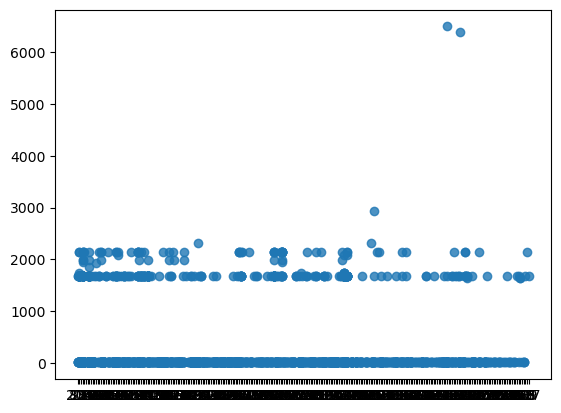

In [149]:
## regression based on wage vs employment duration?

jobs.EMPLOYMENT_BEGIN_DATE = pd.to_datetime(jobs.EMPLOYMENT_BEGIN_DATE)
jobs.EMPLOYMENT_END_DATE = pd.to_datetime(jobs.EMPLOYMENT_END_DATE)

jobs['EMPLOYMENT_TIME'] = jobs.EMPLOYMENT_END_DATE - jobs.EMPLOYMENT_BEGIN_DATE
jobs['EMPLOYMENT_TIME'] = jobs['EMPLOYMENT_TIME'].astype(str)
jobs['EMPLOYMENT_TIME_x'] = jobs['EMPLOYMENT_TIME'].replace(r' days', '', regex=True)
jobs['EMPLOYMENT_TIME_x']

sns.regplot(data = jobs, x='EMPLOYMENT_TIME_x', y='WAGE_OFFER')

